In [1]:
#import just about everything that I'll need
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For all of the models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Decision Tree 
from sklearn.tree import DecisionTreeClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# K-Means
from sklearn.cluster import KMeans

# Naive Bayes
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Neural Networks: TO DO - MLPClassifier doesn't seem to work
from sklearn.neural_network import MLPClassifier

# Multiple Regression -- reference: https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9
import statsmodels.api as sm
# TO DO: figure out how to graph multiple linear regression
# https://stackoverflow.com/questions/42261976/how-to-plot-statsmodels-linear-regression-ols-cleanly
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.regressionplots.plot_fit.html
# https://www.statsmodels.org/devel/examples/notebooks/generated/regression_plots.html

df = pd.read_csv("survey_cleaner1.csv")

Cleaning data

In [2]:
df = df.drop(columns=["state", "Unnamed: 0"])

In [3]:
median = df["Age"].median()
df.columns

Index(['Age', 'Gender', 'Country', 'self_employed', 'family_history',
       'treatment', 'work_interfere', 'no_employees', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence'],
      dtype='object')

In [4]:
# find the columns with nulls in it
df.info()
df.work_interfere.isnull().sum() #self employed has 18 null, #work_interfere has 263 null, check out options
df.work_interfere.unique()

# replace NaNs in work_intefere with "I Don't Know"
df.work_interfere.fillna("Don't Know",inplace=True)
# replace NaN's in self_employed with "No" because only 18 null and probably don't 
df.self_employed.fillna("No", inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        1253 non-null   int64 
 1   Gender                     1253 non-null   object
 2   Country                    1253 non-null   object
 3   self_employed              1235 non-null   object
 4   family_history             1253 non-null   object
 5   treatment                  1253 non-null   object
 6   work_interfere             990 non-null    object
 7   no_employees               1253 non-null   object
 8   remote_work                1253 non-null   object
 9   tech_company               1253 non-null   object
 10  benefits                   1253 non-null   object
 11  care_options               1253 non-null   object
 12  wellness_program           1253 non-null   object
 13  seek_help                  1253 non-null   object
 14  anonymit

End of cleaning. 

**Modeling begins**

### Evaluating Model 
How often was the model correct?

The following function evaluates:
* Classification accuracy: percentage of correct predictions
* Null accuracy: accuracy that could be achieved by always predicting the most frequent class
* Percentage of ones (treatment=1, did get treatment)
* Percentage of zeros (treatment=0, did not get treatment)
* Confusion matrix: Table that describes the performance of a classification model
    * True Positives (TP): we correctly predicted that the target variable occurred (treatment) i.e. the person did seek treatment for mental health
    * True Negatives (TN): we correctly predicted that the target variable DID NOT occur i.e. the person did NOT seek treatment
    * False Positives (FP): we predicted that they got treatment, when in fact they did not
    * False Negatives (FN): we predicted that they did not get treatment, when in fact they did
* False Positive Rate
* Precision of Positive value (??)
* AUC: the percentage of the ROC plot that is underneath the curve
    * 0.9-1 = excellent (A)
    * 0.8-0.9 = good (B)
    * 0.7-0.8 = okay (C)
    * 0.6-0.7 = poor (D)
    * 0.5-0.6 = fail (F)


In [5]:
# Results Dictionary to hold each result

# Structure: 'model_name': ['model_name', overall_accuracy, true_positive, true_negative, false_pos, false_neg]
results_dict = {}

def evaluate_model(model_name, model, y_test, y_pred, X_test, plot=False, kmeans=False):
    # Classification accuracy: percentage of correct predictions
    class_accuracy = metrics.accuracy_score(y_test, y_pred)
    print('Accuracy:', class_accuracy)
    
    # Null accuracy: accuracy that could be acheived by always predicting the most frequent classs
    # examine the class distribution of the testing set (using a Pandas Series method)
    print('Null accuracy:\n', y_test.value_counts())
    
    # percentage of ones i.e. people who got mental health treatment
    print('Percentage of people who got treatment:', y_test.mean())
    
    # percentage of zeros i.e. people who DID NOT get mental health treatment
    print('Percentage of people who did not get treatment:', 1-y_test.mean())
    
    # Confusion matrix 
    # save confusion matrix and slice into True Negative, False Positive, False Negative, True Positive
    tn, fp, fn, tp = metrics.confusion_matrix(y_test,y_pred).ravel()
    confusion = metrics.confusion_matrix(y_test,y_pred)
    
    # calculate rates of true negative, false positive, etc.
    # tp + fn = all values that were actually 1
    # fp + tn = all values that were actually 0
    tpr = tp / float(tp + fn)
    tnr = tn / float(tn + fp)
    fpr = fp / float(fp + tn)
    fnr = fn / float(fn + tp)
    
    # add results to dictionary
    results_dict[model_name] = [model_name, class_accuracy, tpr, tnr, fpr, fnr]
    
    # Visualize Confusion Matrix
    sns.heatmap(confusion, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Metrics Computed from a Confusion Matrix
    
    # Classification Accuracy: How often was the classifier correct, overall?
    print('Classification Accuracy:', class_accuracy)
    
    # Classification Error: How often was the classifier incorrect, overall?
    print('Classification Error:', 1-class_accuracy)
    
    # Precision: When a positive value is predicted, how often is the prediction correct?
    print('Precision:', metrics.precision_score(y_test, y_pred))
    
    ###########################################
    # ROC Curves and Area Under the Curve (AUC)
    ###########################################
    
    # Question: Wouldn't it be nice if we could see how sensitivity and specificity 
    # are affected by various thresholds, without actually changing the threshold?
    # Answer: Plot the ROC curve!
    
    # AUC score - predictions is second argument, NOT predicted probabilties -- still trying to figure this stuff out
    print('AUC Score', metrics.roc_auc_score(y_test, y_pred))
    
    # check if model==KMeans, because KMeans has no predict_proba function
    if kmeans==True:
        return
    
    else:
    
        # No cross validation for now
        # calculate cross-validated AUC 
        # print('Cross-validated AUC:', cross_val_score(model, X_test, y, cv=5, scoring='roc_auc').mean())

        # get predicted PROBABILITIES for treatment = 1
        y_prob = model.predict_proba(X_test)[:, 1]


        # AUC is the percentage of the ROC plot that is underneath the curve
        # Higher value = better classifier 
        roc_auc = metrics.roc_auc_score(y_test, y_prob)

        # First argument is true values, second arg is predicted PROBabilties
        # we do not use y_pred bc will incorrect results without throwing an error
        # roc_curve returns: false positive rate, true positive rate, thresholds

        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
        if plot==True:
            plt.figure()

            plt.plot(fpr,tpr, color="green", label="ROC curve (area= %0.2f)" % roc_auc)
            plt.plot([0,1],[0,1], color='gray', linestyle='--')
            plt.xlabel('False Positive Rate (1 - Specificity)')
            plt.ylabel('True Positive Rate (Sensitivity)')
            plt.legend(loc="lower right")
            plt.show()

            # define a function that accepts a threshholds and prints sensitivity and specificity

            def eval_threshold(threshold):
                # Sensitivity: When the actual value is positive, how often is the prediction correct?
                # Specificity: When the actual value is negative, how often is the prediction correct?

                print('Specificty for ' + str(threshold) + ':', 1-fpr[thresholds>threshold][-1])

                # One way of setting threshold
                predict_mine = np.where(y_prob > 0.50, 1, 0)
                confusion = metrics.confusion_matrix(y_test, predict_mine)
                print(confusion)

                return accuracy


### Question to consider after running models
?? how do the results intersect with that big group of people I identified with UpSetR? If I split it into that group and not that group, how does the model(s) hold up?

?? figure out a good way to tune hyperparameters - maybe that GridSearch thing?

### Models to try:
- Decision Tree
- Random Forest
- Logistic Regression
- Naive Bayes (3 kinds)
- Neural Networks -- TO DO: if I get to it
- K-means
- Multiple Regression (on identified regressors, see earlier document)

In [6]:
# Encode data with Label Encoder
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    list(le.classes_)

# Scale "Age" to be closer to the others
scaler = MinMaxScaler()
df['Age'] = scaler.fit_transform(df[['Age']])

In [7]:
# split the data into features and label, and training and test sets
def split_data(df):
    # Split data into features and label (X, y)
    y = df.treatment # label/dependent variable
    X = df.drop(columns=["treatment"]) # features/independent variables

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=56) # 70% training and 30% test
    
    return X_train, X_test, y_train, y_test

Accuracy: 0.75
Null accuracy:
 0    191
1    185
Name: treatment, dtype: int64
Percentage of people who got treatment: 0.4920212765957447
Percentage of people who did not get treatment: 0.5079787234042553


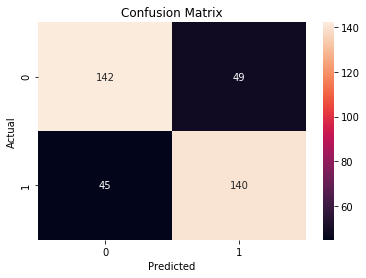

Classification Accuracy: 0.75
Classification Error: 0.25
Precision: 0.7407407407407407
AUC Score 0.7501061270694779


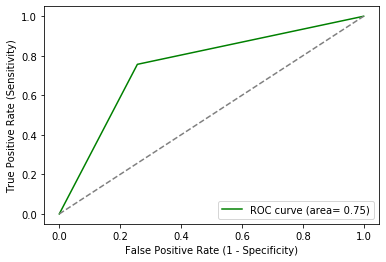

In [8]:
# Decision Tree
def DecisionTree(df):
    # Split data into features and label (X, y)
    X_train, X_test, y_train, y_test = split_data(df) 

    # Decision Tree classifier object
    clf = DecisionTreeClassifier(random_state = 23)

    # Train Decision Tree classifer
    clf = clf.fit(X_train,y_train)

    # Try model on test dataset
    y_predict = clf.predict(X_test)

    evaluate_model('Decision Tree',clf, y_test, y_predict, X_test, plot=True)

DecisionTree(df)

Accuracy: 0.7898936170212766
Null accuracy:
 0    191
1    185
Name: treatment, dtype: int64
Percentage of people who got treatment: 0.4920212765957447
Percentage of people who did not get treatment: 0.5079787234042553


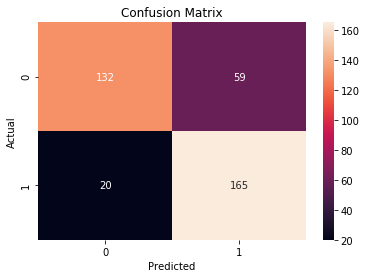

Classification Accuracy: 0.7898936170212766
Classification Error: 0.21010638297872342
Precision: 0.7366071428571429
AUC Score 0.7914956841658414


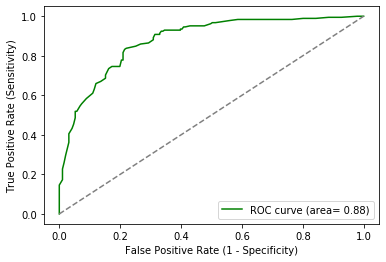

In [9]:
def RandomForest(df):
    # Split data into features and label (X, y)
    X_train, X_test, y_train, y_test = split_data(df) 

    # Random Forest classifier object
    clf = RandomForestClassifier(random_state=23)


    # Train classifer
    clf = clf.fit(X_train,y_train)

    # Try model on test dataset
    y_predict = clf.predict(X_test)

    evaluate_model('Random Forest', clf, y_test, y_predict, X_test, plot=True)

RandomForest(df)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7792553191489362
Null accuracy:
 0    191
1    185
Name: treatment, dtype: int64
Percentage of people who got treatment: 0.4920212765957447
Percentage of people who did not get treatment: 0.5079787234042553


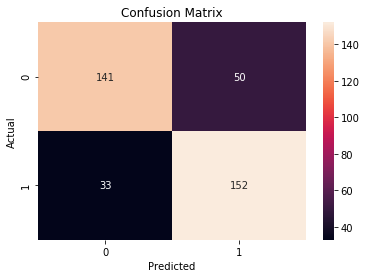

Classification Accuracy: 0.7792553191489362
Classification Error: 0.2207446808510638
Precision: 0.7524752475247525
AUC Score 0.7799207584547899


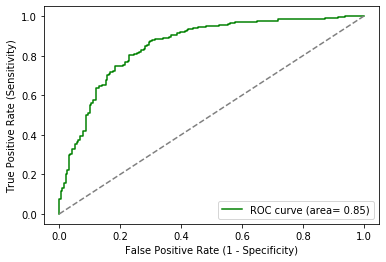

In [10]:
def Logistic(df):
    # Split data into features and label (X, y)
    X_train, X_test, y_train, y_test = split_data(df) 

    # Logistic Regression object and fit
    clf = LogisticRegression(random_state=23).fit(X_train,y_train)
    
    # Try model on test dataset
    y_predict = clf.predict(X_test)

    evaluate_model('Logistic',clf, y_test, y_predict, X_test, plot=True)

Logistic(df)

**Naive Bayes Classifiers**  
Info from here: https://scikit-learn.org/stable/modules/naive_bayes.html
Try:
* Gaussian Naive Bayes, because simplest and most common
* Multinomial Naive Bayes, also pretty common, assumes attributes might have something to do with each other
* Complement Naive Bayes, because good for class-imbalanced datasets, which I'm pretty sure this is


GAUSSIAN NAIVE BAYES
Accuracy: 0.7952127659574468
Null accuracy:
 0    191
1    185
Name: treatment, dtype: int64
Percentage of people who got treatment: 0.4920212765957447
Percentage of people who did not get treatment: 0.5079787234042553


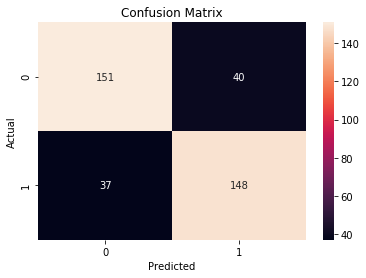

Classification Accuracy: 0.7952127659574468
Classification Error: 0.20478723404255317
Precision: 0.7872340425531915
AUC Score 0.7952879581151833


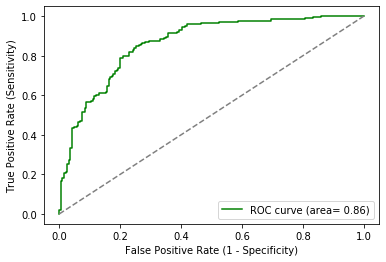

MULTINOMIAL NAIVE BAYES
Accuracy: 0.7792553191489362
Null accuracy:
 0    191
1    185
Name: treatment, dtype: int64
Percentage of people who got treatment: 0.4920212765957447
Percentage of people who did not get treatment: 0.5079787234042553


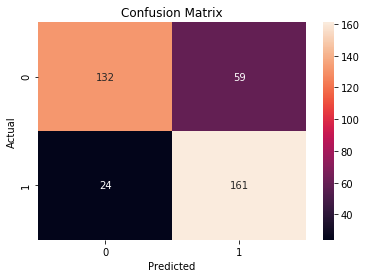

Classification Accuracy: 0.7792553191489362
Classification Error: 0.2207446808510638
Precision: 0.7318181818181818
AUC Score 0.7806848733550306


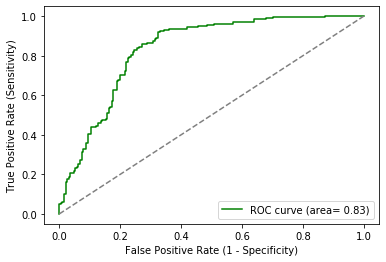

COMPLEMENT NAIVE BAYES
Accuracy: 0.7872340425531915
Null accuracy:
 0    191
1    185
Name: treatment, dtype: int64
Percentage of people who got treatment: 0.4920212765957447
Percentage of people who did not get treatment: 0.5079787234042553


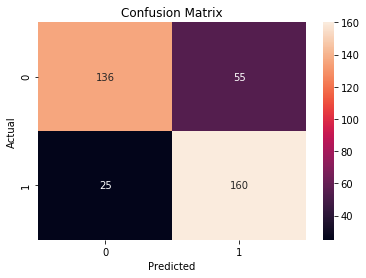

Classification Accuracy: 0.7872340425531915
Classification Error: 0.21276595744680848
Precision: 0.7441860465116279
AUC Score 0.7884533748408095


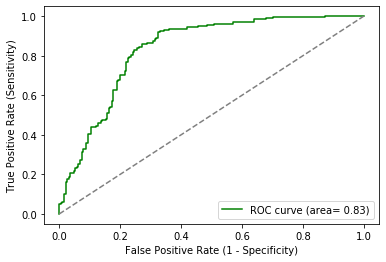

In [11]:
def NaiveBayes(df):
    # Split data into features and label (X, y)
    X_train, X_test, y_train, y_test = split_data(df) 
    
    ### Gaussian Naive Bayes
    print("GAUSSIAN NAIVE BAYES")
    
    gaussian_clf = GaussianNB().fit(X_train,y_train)
    
    # Try model on test dataset
    y_predict = gaussian_clf.predict(X_test)

    evaluate_model('Gaussian Bayes', gaussian_clf, y_test, y_predict, X_test, plot=True)
    
    ### Multinomial Naive Bayes
    print("MULTINOMIAL NAIVE BAYES")
    
    multi_clf = MultinomialNB().fit(X_train,y_train)
    
    # Try model on test dataset
    y_predict = multi_clf.predict(X_test)

    evaluate_model('Multinomial Bayes',multi_clf, y_test, y_predict, X_test, plot=True)
    
    ### Complement Naive Bayes
    print("COMPLEMENT NAIVE BAYES")
    
    complement_clf = ComplementNB().fit(X_train,y_train)
    
    # Try model on test dataset
    y_predict = complement_clf.predict(X_test)

    evaluate_model('Complement Bayes',complement_clf, y_test, y_predict, X_test, plot=True)
    
    
NaiveBayes(df)

Accuracy: 0.48138297872340424
Null accuracy:
 0    191
1    185
Name: treatment, dtype: int64
Percentage of people who got treatment: 0.4920212765957447
Percentage of people who did not get treatment: 0.5079787234042553


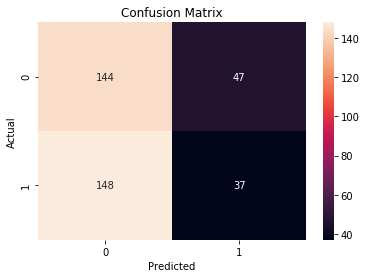

Classification Accuracy: 0.48138297872340424
Classification Error: 0.5186170212765957
Precision: 0.44047619047619047
AUC Score 0.4769633507853403


In [12]:
def KMeansClf(df):
    # Split data into features and label (X, y)
    X_train, X_test, y_train, y_test = split_data(df) 
    
    clf = KMeans(n_clusters=2, random_state=23).fit(X_train)
    
    y_pred = clf.predict(X_test)
    
    evaluate_model('KMeans',clf, y_test, y_pred, X_test, plot=True, kmeans=True)

KMeansClf(df)

In [13]:
# note that this DOES NOT WORK
def NN(df):
    # Split data into features and label (X, y)
    X_train, X_test, y_train, y_test = split_data(df) 

    # NN object and fit
    clf = MLPClassifier(random_state=23).fit(X_train,y_train)
    
    # Try model on test dataset
    y_predict = clf.predict(X_test)

    evaluate_model(clf, y_test, y_predict, X_test, plot=True)

Accuracy: 0.7819148936170213
Null accuracy:
 0    191
1    185
Name: treatment, dtype: int64
Percentage of people who got treatment: 0.4920212765957447
Percentage of people who did not get treatment: 0.5079787234042553


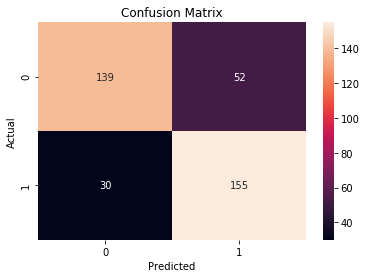

Classification Accuracy: 0.7819148936170213
Classification Error: 0.21808510638297873
Precision: 0.748792270531401
AUC Score 0.782793264468657
                                 OLS Regression Results                                
Dep. Variable:              treatment   R-squared (uncentered):                   0.749
Model:                            OLS   Adj. R-squared (uncentered):              0.742
Method:                 Least Squares   F-statistic:                              110.6
Date:                Sun, 23 Aug 2020   Prob (F-statistic):                   1.52e-237
Time:                        17:47:25   Log-Likelihood:                         -343.30
No. Observations:                 877   AIC:                                      732.6
Df Residuals:                     854   BIC:                                      842.5
Df Model:                          23                                                  
Covariance Type:            nonrobust                            

In [24]:
# Multiple Regression
def MultipleRegression(df, x_features = 'all'):
    # Split data into features and label (X, y)
    y = df.treatment # label/dependent variable
    
    if x_features=='all':
        X = df.drop(columns=["treatment"]) # features/independent variables
    else:
        X = df[x_features]
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=56) # 70% training and 30% test

    
    model = sm.OLS(y_train, X_train).fit()
    y_pred = round(model.predict(X_test))
    
    evaluate_model('Multiple Regression', model, y_test, y_pred, X_test, plot=True, kmeans=True)
    
    print(model.summary())
    
    # TO DO: plot somehow
    
MultipleRegression(df)

In [15]:
# Multiple Regression on mental_health_interview, obs_consequence, tech_company, self_employed
MultipleRegression(df, ['mental_health_interview', 'obs_consequence', 'tech_company', 'self_employed'])

                                 OLS Regression Results                                
Dep. Variable:              treatment   R-squared (uncentered):                   0.502
Model:                            OLS   Adj. R-squared (uncentered):              0.500
Method:                 Least Squares   F-statistic:                              219.8
Date:                Sun, 23 Aug 2020   Prob (F-statistic):                   1.82e-130
Time:                        17:38:34   Log-Likelihood:                         -643.36
No. Observations:                 877   AIC:                                      1295.
Df Residuals:                     873   BIC:                                      1314.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

**Analysis**: Half of the variance is explained by those four variables which is interesting because half of the data has the same values for those 4 variables.

In [25]:
results_df = pd.DataFrame.from_dict(results_dict, orient='index', 
                                    columns=['Name', 'Overall Accuracy', 'True Positive Rate', 
                                             'True Negative Rate', 'False Positive Rate', 
                                             'False Negative Rate'])
results_df

,Name,Overall Accuracy,True Positive Rate,True Negative Rate,False Positive Rate,False Negative Rate
Decision Tree,Decision Tree,0.750000,0.756757,0.743455,0.256545,0.243243
Random Forest,Random Forest,0.789894,0.891892,0.691099,0.308901,0.108108
Logistic,Logistic,0.779255,0.821622,0.738220,0.261780,0.178378
Gaussian Bayes,Gaussian Bayes,0.795213,0.800000,0.790576,0.209424,0.200000
Multinomial Bayes,Multinomial Bayes,0.779255,0.870270,0.691099,0.308901,0.129730
Complement Bayes,Complement Bayes,0.787234,0.864865,0.712042,0.287958,0.135135
KMeans,KMeans,0.481383,0.200000,0.753927,0.246073,0.800000
Multiple Regression,Multiple Regression,0.781915,0.837838,0.727749,0.272251,0.162162


**Analysis**  
KMeans, with no tuning, did really badly, but otherwise all of the models did really comparably. If I didn't do anything else, I would pick Gaussian Bayes, both because it did the best and because its False Positive and False Negative Rates are pretty much equal, which means that I would have an equal chance not being correct in both directions, which is easier to both think about and handle in general.
